## 1.Word Embedding

In [2]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F

# 关于word embedding, 以序列建模为例
# 考虑source sentence 和 target sentence
# 构建序列, 序列的字符以其在词表中的索引的形式表示
batch_size = 2

# 单词表大小
max_num_src_words = 8
max_num_tgt_words = 8

model_dim = 4  # embedding维度

# 序列的最大长度
max_src_seq_len = 5
max_tgt_seq_len = 5

# src_len = torch.randint(2, 5, (batch_size,))
# tgt_len = torch.randint(2, 5, (batch_size,))
src_len = torch.Tensor([2, 4]).to(torch.int32)
tgt_len = torch.Tensor([4, 3]).to(torch.int32)

# 单词索引构成源句子和目标句子,构建batch， 并且做了padding, 默认值为0
# src_seq = torch.cat([torch.unsqueeze(F.pad(torch.randint(1, max_num_src_words, (L,)), (0, max_src_seq_len-L)), 0) for L in src_len])

sequences = []
for L in src_len:
    seq = torch.randint(1, max_num_src_words, (L,)) # 随机序列
    seq_padded = F.pad(seq, (0, max_src_seq_len - L)) # 右填充
    sequences.append(torch.unsqueeze(seq_padded, 0)) # 增加batch维度
src_seq = torch.cat(sequences, 0) # 拼接成batch


# tgt_seq = torch.cat([torch.unsqueeze(F.pad(torch.randint(1, max_num_tgt_words, (L,)), (0, max_tgt_seq_len-L)), 0) for L in tgt_len])

sequences = []
for L in tgt_len:
    seq = torch.randint(1, max_num_tgt_words, (L,)) # 随机序列
    seq_padded = F.pad(seq, (0, max_tgt_seq_len - L)) # 右填充
    sequences.append(torch.unsqueeze(seq_padded, 0)) # 增加batch维度
tgt_seq = torch.cat(sequences, 0) # 拼接成batch

# 构造embedding
src_Embedding_table = nn.Embedding(max_num_src_words + 1, model_dim)  # +1是因为0号索引是padding
tgt_Embedding_table = nn.Embedding(max_num_tgt_words + 1, model_dim)  # +1是因为0号索引是padding
src_Embedding = src_Embedding_table(src_seq)
tgt_Embedding = tgt_Embedding_table(tgt_seq)

print(src_Embedding_table.weight)
print(src_seq)
print(src_Embedding)


Parameter containing:
tensor([[-1.5904e+00, -6.3486e-01, -8.3674e-01, -4.1296e-01],
        [-1.3340e+00, -3.2988e-01,  1.1484e+00,  1.5116e+00],
        [-1.5360e+00, -1.6954e-01,  3.0873e-01,  9.3021e-01],
        [-1.1008e+00,  1.1122e-03,  1.7799e+00,  9.0703e-02],
        [-1.0853e-03, -1.5126e+00, -3.9077e-01, -1.2875e+00],
        [ 1.6801e-01,  1.5525e+00,  2.0833e+00,  4.1679e-01],
        [-8.0832e-01,  7.1268e-01, -1.1848e+00, -4.6587e-01],
        [-1.1060e+00, -5.5355e-01, -1.6756e-01, -1.5519e-01],
        [-1.6752e+00, -7.2126e-02, -1.2431e+00,  1.6306e+00]],
       requires_grad=True)
tensor([[4, 6, 0, 0, 0],
        [6, 4, 6, 7, 0]])
tensor([[[-1.0853e-03, -1.5126e+00, -3.9077e-01, -1.2875e+00],
         [-8.0832e-01,  7.1268e-01, -1.1848e+00, -4.6587e-01],
         [-1.5904e+00, -6.3486e-01, -8.3674e-01, -4.1296e-01],
         [-1.5904e+00, -6.3486e-01, -8.3674e-01, -4.1296e-01],
         [-1.5904e+00, -6.3486e-01, -8.3674e-01, -4.1296e-01]],

        [[-8.0832e-01,  

### 总结

Word Embedding 演示了序列建模中如何构建词嵌入：

```
词索引序列 → Padding 对齐 → Embedding 查表 → 稠密向量
```

**步骤：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1. 定义参数 | `batch_size=2, model_dim=4` | 2 个样本，嵌入维度 4 |
| 2. 生成序列 | `torch.randint(1, 8, (L,))` | 随机生成词索引 |
| 3. Padding | `F.pad(seq, (0, max_len-L))` | 右侧填 0，对齐长度 |
| 4. 组 batch | `torch.cat(..., dim=0)` | 拼成 `(batch, seq_len)` |
| 5. 嵌入 | `nn.Embedding(9, 4)` | 查表得到向量 |

**形状变化：**

```
src_seq:       (2, 5)      # 2 个句子，每句 5 个词索引
src_Embedding: (2, 5, 4)   # 每个词变成 4 维向量
```

## 2.Position Embedding

In [3]:
import math

# 正弦位置编码
# pos: 位置索引 (0, 1, 2, ...)
# i: 维度索引
# PE(pos, 2i)   = sin(pos / 10000^(2i/d))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d))

def sinusoidal_position_embedding(max_len, dim):
    """
    生成正弦位置编码
    max_len: 最大序列长度
    dim: embedding维度
    返回: (max_len, dim) 的位置编码矩阵
    """
    pe = torch.zeros(max_len, dim)
    pos = torch.arange(0, max_len).unsqueeze(1).float()  # (max_len, 1)
    # 计算分母: 10000^(2i/d) = exp(2i * log(10000) / d)
    div = torch.exp(torch.arange(0, dim, 2).float() * -(math.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(pos * div)  # 偶数维度用sin
    pe[:, 1::2] = torch.cos(pos * div)  # 奇数维度用cos
    return pe

# 生成位置编码
src_pos_embedding = sinusoidal_position_embedding(max_src_seq_len, model_dim)  # (5, 4)
tgt_pos_embedding = sinusoidal_position_embedding(max_tgt_seq_len, model_dim)  # (5, 4)

# Word Embedding + Position Embedding
src_input = src_Embedding + src_pos_embedding  # (2, 5, 4) + (5, 4) 广播
tgt_input = tgt_Embedding + tgt_pos_embedding  # (2, 5, 4) + (5, 4) 广播

print("位置编码 shape:", src_pos_embedding.shape)
print("位置编码:\n", src_pos_embedding)
print("\n最终输入 shape:", src_input.shape)
print("最终输入 (Word + Position):\n", src_input)

位置编码 shape: torch.Size([5, 4])
位置编码:
 tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992]])

最终输入 shape: torch.Size([2, 5, 4])
最终输入 (Word + Position):
 tensor([[[-1.0853e-03, -5.1261e-01, -3.9077e-01, -2.8745e-01],
         [ 3.3150e-02,  1.2530e+00, -1.1748e+00,  5.3408e-01],
         [-6.8109e-01, -1.0510e+00, -8.1674e-01,  5.8684e-01],
         [-1.4493e+00, -1.6249e+00, -8.0674e-01,  5.8659e-01],
         [-2.3472e+00, -1.2885e+00, -7.9675e-01,  5.8624e-01]],

        [[-8.0832e-01,  1.7127e+00, -1.1848e+00,  5.3413e-01],
         [ 8.4039e-01, -9.7231e-01, -3.8077e-01, -2.8750e-01],
         [ 1.0098e-01,  2.9653e-01, -1.1648e+00,  5.3393e-01],
         [-9.6484e-01, -1.5435e+00, -1.3757e-01,  8.4436e-01],
         [-2.3472e+00, -1.2885e+00, -7.9675e-01,  5.8624e-01]]],
       grad_fn=<AddBackward0>)


### 总结

Position Embedding 为序列注入位置信息，与 Word Embedding 相加作为 Transformer 输入：

```
Word Embedding + Position Embedding = 最终输入
   (语义信息)       (位置信息)
```

**正弦位置编码公式：**
- 偶数维度：$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d})$
- 奇数维度：$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d})$

**代码步骤：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1. 位置索引 | `pos = torch.arange(0, max_len).unsqueeze(1)` | 形状 (seq_len, 1) |
| 2. 频率分母 | `div = torch.exp(torch.arange(0, dim, 2) * -(log(10000)/dim))` | 等价于 1/10000^(2i/d) |
| 3. 填充 sin/cos | `pe[:, 0::2] = sin`, `pe[:, 1::2] = cos` | 偶数列 sin，奇数列 cos |
| 4. 广播相加 | `src_Embedding + src_pos_embedding` | (2,5,4) + (5,4) → (2,5,4) |

**为什么用 sin/cos 成对？**
- 可通过线性变换表示相对位置：$PE_{pos+k} = M \cdot PE_{pos}$
- 模型能学习"词与词之间的距离"

**形状变化：**
```
src_pos_embedding: (5, 4)      # 位置编码
src_Embedding:     (2, 5, 4)   # 词嵌入
src_input:         (2, 5, 4)   # 广播相加，最终输入
```

## 3.Encoder Self-Attention Mask

In [4]:
# Encoder Self-Attention Mask
# 目的：屏蔽 padding 位置，不让它们参与注意力计算

# 第一步：构建有效位置向量 (batch, seq_len)
# 1 = 有效位置，0 = padding
valid_encoder_pos = torch.cat([
    torch.unsqueeze(
        torch.cat([torch.ones(L), torch.zeros(max_src_seq_len - L)]), 0
    ) 
    for L in src_len
])

print("有效位置向量 shape:", valid_encoder_pos.shape)
print("有效位置向量:\n", valid_encoder_pos)
# 样本0: [1, 1, 0, 0, 0]  前2个有效
# 样本1: [1, 1, 1, 1, 0]  前4个有效

# 第二步：扩展成矩阵 (batch, seq_len, seq_len)
# 外积: (batch, seq_len, 1) × (batch, 1, seq_len)
valid_encoder_pos_matrix = torch.bmm(
    valid_encoder_pos.unsqueeze(-1),  # (2, 5, 1)，2个（5，1）的列向量
    valid_encoder_pos.unsqueeze(1)    # (2, 1, 5)，2个（1，5）的行向量
)

print("\nEncoder Self-Attention Mask shape:", valid_encoder_pos_matrix.shape)
print("样本0的mask:\n", valid_encoder_pos_matrix[0])
print("样本1的mask:\n", valid_encoder_pos_matrix[1])

# 转换为 bool 类型，后续用于屏蔽
encoder_self_attn_mask = valid_encoder_pos_matrix.bool()
print("\n最终mask (bool):\n", encoder_self_attn_mask)

有效位置向量 shape: torch.Size([2, 5])
有效位置向量:
 tensor([[1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0.]])

Encoder Self-Attention Mask shape: torch.Size([2, 5, 5])
样本0的mask:
 tensor([[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
样本1的mask:
 tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]])

最终mask (bool):
 tensor([[[ True,  True, False, False, False],
         [ True,  True, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[ True,  True,  True,  True, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True, False],
         [False, False, False, False, False]]])


### 总结

Encoder Self-Attention Mask 用于屏蔽 padding 位置，防止无意义的填充参与注意力计算：

```
有效位置 → 正常计算注意力
padding  → 屏蔽（softmax 后权重为 0）
```

**代码步骤：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1. 有效位置向量 | `torch.cat([ones(L), zeros(max_len-L)])` | 1=有效，0=padding |
| 2. 扩展成矩阵 | `torch.bmm(pos.unsqueeze(-1), pos.unsqueeze(1))` | 外积得到 (batch, seq, seq) |
| 3. 转布尔类型 | `.bool()` | 方便后续 masked_fill |

**外积原理：**
```
列向量 (5,1) × 行向量 (1,5) → 矩阵 (5,5)

[1]                     [[1,1,0,0,0],
[1]   × [1,1,0,0,0]  =   [1,1,0,0,0],
[0]                      [0,0,0,0,0],
[0]                      [0,0,0,0,0],
[0]                      [0,0,0,0,0]]
```

**Mask 含义：**
- `mask[i][j] = True`：query_i 可以看 key_j
- `mask[i][j] = False`：屏蔽，query_i 不能看 key_j

**形状变化：**
```
valid_encoder_pos:        (2, 5)      # 有效位置向量
valid_encoder_pos_matrix: (2, 5, 5)   # 注意力 mask 矩阵
```

## 4.Intra-Attention Mask

In [5]:
# Intra-Attention Mask (Cross-Attention)
# 目的：Decoder 看 Encoder 时，屏蔽双方的 padding

# Decoder 有效位置 (batch, tgt_seq_len)
valid_decoder_pos = torch.cat([
    torch.unsqueeze(
        torch.cat([torch.ones(L), torch.zeros(max_tgt_seq_len - L)]), 0
    ) 
    for L in tgt_len
])

print("Encoder 有效位置:", valid_encoder_pos)  # src_len = [2, 4]
print("Decoder 有效位置:", valid_decoder_pos)  # tgt_len = [4, 3]

# Cross-Attention Mask: (batch, tgt_seq_len, src_seq_len)
# Decoder query (tgt) × Encoder key (src)
cross_attn_mask = torch.bmm(
    valid_decoder_pos.unsqueeze(-1),  # (2, 5, 1)
    valid_encoder_pos.unsqueeze(1)    # (2, 1, 5)
).bool()

print("\nCross-Attention Mask shape:", cross_attn_mask.shape)
print("样本0的mask (tgt_len=4, src_len=2):\n", cross_attn_mask[0].int())
print("样本1的mask (tgt_len=3, src_len=4):\n", cross_attn_mask[1].int())

Encoder 有效位置: tensor([[1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0.]])
Decoder 有效位置: tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 0.]])

Cross-Attention Mask shape: torch.Size([2, 5, 5])
样本0的mask (tgt_len=4, src_len=2):
 tensor([[1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
样本1的mask (tgt_len=3, src_len=4):
 tensor([[1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)


### 总结

Cross-Attention 让 Decoder 查询 Encoder 的信息，Mask 屏蔽双方的 padding：

```
Decoder (Q) → 发起查询："源句子哪部分和我相关？"
Encoder (KV) → 被查询：提供源句子的语义信息
```

**与 Self-Attention 的区别：**

| 类型 | Query | Key/Value | Mask 形状 |
|------|-------|-----------|-----------|
| Self-Attention | 自己 | 自己 | (batch, seq, seq) |
| Cross-Attention | Decoder | Encoder | (batch, tgt_len, src_len) |

**代码步骤：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1. Decoder 有效位置 | `valid_decoder_pos` | tgt_len = [4, 3] |
| 2. Encoder 有效位置 | `valid_encoder_pos` | src_len = [2, 4] |
| 3. 外积得 Mask | `bmm(decoder.unsqueeze(-1), encoder.unsqueeze(1))` | (batch, tgt_len, src_len) |

**Mask 含义：**
- `mask[i][j] = True`：Decoder 位置 i 可以看 Encoder 位置 j
- `mask[i][j] = False`：屏蔽（任一方是 padding）

**形状变化：**
```
valid_decoder_pos: (2, 5)       # Decoder 有效位置
valid_encoder_pos: (2, 5)       # Encoder 有效位置
cross_attn_mask:   (2, 5, 5)    # Cross-Attention Mask
```

## 5.Decoder Self-Attention Mask

In [6]:
# Decoder Self-Attention Mask
# 目的：1. 屏蔽 padding  2. 屏蔽未来位置（不能偷看答案）

# 第一步：Causal Mask（因果掩码）- 下三角矩阵
# 每个位置只能看自己和之前的位置
causal_mask = torch.tril(torch.ones(max_tgt_seq_len, max_tgt_seq_len))
print("Causal Mask (下三角):")
print(causal_mask)

# 第二步：Padding Mask - 有效位置矩阵
valid_decoder_pos_matrix = torch.bmm(
    valid_decoder_pos.unsqueeze(-1),  # (2, 5, 1)
    valid_decoder_pos.unsqueeze(1)    # (2, 1, 5)
)
print("\nPadding Mask 样本0 (tgt_len=4):")
print(valid_decoder_pos_matrix[0])

# 第三步：两者相乘（同时满足两个条件）
decoder_self_attn_mask = (causal_mask * valid_decoder_pos_matrix).bool() # 哈达玛积，对应元素相乘

print("\nDecoder Self-Attention Mask shape:", decoder_self_attn_mask.shape)
print("样本0的mask (tgt_len=4):\n", decoder_self_attn_mask[0].int())
print("样本1的mask (tgt_len=3):\n", decoder_self_attn_mask[1].int())

Causal Mask (下三角):
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

Padding Mask 样本0 (tgt_len=4):
tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]])

Decoder Self-Attention Mask shape: torch.Size([2, 5, 5])
样本0的mask (tgt_len=4):
 tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
样本1的mask (tgt_len=3):
 tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)


### 总结

Decoder Self-Attention Mask 需要同时满足两个约束：

```
1. Causal Mask：不能看未来（防止作弊）
2. Padding Mask：不能看 padding（无意义填充）
```

**代码步骤：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1. Causal Mask | `torch.tril(torch.ones(seq_len, seq_len))` | 下三角矩阵 |
| 2. Padding Mask | `bmm(pos.unsqueeze(-1), pos.unsqueeze(1))` | 有效位置矩阵 |
| 3. 相乘 | `causal_mask * padding_mask` | Hadamard Product，同时满足两个条件 |

**三种 Mask 对比：**

| Mask | 约束 | 形状 |
|------|------|------|
| Encoder Self-Attention | 只屏蔽 padding | (batch, src_len, src_len) |
| Cross-Attention | 屏蔽双方 padding | (batch, tgt_len, src_len) |
| Decoder Self-Attention | padding + 未来 | (batch, tgt_len, tgt_len) |

**Causal Mask 示意：**
```
位置0: [1, 0, 0, 0, 0]  ← 只能看自己
位置1: [1, 1, 0, 0, 0]  ← 能看 0, 1
位置2: [1, 1, 1, 0, 0]  ← 能看 0, 1, 2
...
```

**形状变化：**
```
causal_mask:           (5, 5)      # 下三角
valid_decoder_pos_matrix: (2, 5, 5)   # padding mask
decoder_self_attn_mask:   (2, 5, 5)   # 最终 mask
```

## 6.Multi-Head Self-Attention

In [7]:
# Multi-Head Self-Attention
# 核心公式: Attention(Q,K,V) = softmax(QK^T / sqrt(d_k)) * V

import math

# 参数设置
num_heads = 2
head_dim = model_dim // num_heads  # 4 // 2 = 2

print(f"model_dim={model_dim}, num_heads={num_heads}, head_dim={head_dim}")

# 四个线性层: W_Q, W_K, W_V, W_O
W_Q = nn.Linear(model_dim, model_dim)
W_K = nn.Linear(model_dim, model_dim)
W_V = nn.Linear(model_dim, model_dim)
W_O = nn.Linear(model_dim, model_dim)

# 第一步: 计算 Q, K, V
Q = W_Q(src_input)  # (batch, seq_len, model_dim) = (2, 5, 4)
K = W_K(src_input)
V = W_V(src_input)
print("Q shape:", Q.shape)

# 第二步: 拆成多头
# (batch, seq_len, model_dim) → (batch, seq_len, num_heads, head_dim) → (batch, num_heads, seq_len, head_dim)
Q = Q.view(batch_size, -1, num_heads, head_dim).transpose(1, 2)  # -1自动计算seq_len
K = K.view(batch_size, -1, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, -1, num_heads, head_dim).transpose(1, 2)
print("Q after reshape:", Q.shape)  # (2, 2, 5, 2)

# 第三步: 计算注意力分数 QK^T / sqrt(d_k)
scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(head_dim)
print("Attention scores shape:", scores.shape)  # (2, 2, 5, 5)
print(scores[0, 0])  # 样本0，头0

# 第四步: 应用 Mask (扩展 mask 维度以匹配多头)
# encoder_self_attn_mask: (batch, seq_len, seq_len) → (batch, 1, seq_len, seq_len)
mask_expanded = encoder_self_attn_mask.unsqueeze(1)  # (2, 1, 5, 5)
scores = scores.masked_fill(~mask_expanded, -1e9)   #  scores.masked_fill(条件, 填充值)
  # 条件为 True 的位置 → 填充
  # 条件为 False 的位置 → 保持原值
print("Scores after mask:\n", scores[0, 0])  # 样本0，头0

# 第五步: Softmax 得到注意力权重
attn_weights = F.softmax(scores, dim=-1) # dim=-1 是因为每个 query 对所有 key 的注意力权重要归一化到 1。
print("Attention weights shape:", attn_weights.shape)
print("Attention weights (样本0, 头0):\n", attn_weights[0, 0])

# 第六步: 加权求和 weights * V
attn_output = torch.matmul(attn_weights, V)
print("Attention output shape:", attn_output.shape)  # (2, 2, 5, 2)
print("Attention output (样本0, 头0):\n", attn_output[0, 0])

# 第七步: 拼接多头
# (batch, num_heads, seq_len, head_dim) → (batch, seq_len, num_heads, head_dim) → (batch, seq_len, model_dim)
attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, model_dim)
print("After concat shape:", attn_output.shape)  # (2, 5, 4)

# 第八步: 输出投影
output = W_O(attn_output)
print("Final output shape:", output.shape)  # (2, 5, 4)

model_dim=4, num_heads=2, head_dim=2
Q shape: torch.Size([2, 5, 4])
Q after reshape: torch.Size([2, 2, 5, 2])
Attention scores shape: torch.Size([2, 2, 5, 5])
tensor([[-0.1477, -0.2575, -0.4188, -0.5733, -0.7454],
        [-0.2329, -0.5231, -0.7258, -0.9637, -1.2489],
        [-0.0396, -0.0670, -0.1113, -0.1528, -0.1988],
        [ 0.0640,  0.1294,  0.1915,  0.2576,  0.3342],
        [ 0.1276,  0.2234,  0.3625,  0.4959,  0.6447]],
       grad_fn=<SelectBackward0>)
Scores after mask:
 tensor([[-1.4769e-01, -2.5745e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-2.3294e-01, -5.2313e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]],
       grad_fn=<SelectBackward0>)
Attention weights shape: torch.Size([2, 2, 5, 5])
Attention weights (样本0, 头0):
 tensor([[0.5274, 0.47

### 总结

Multi-Head Self-Attention 是 Transformer 的核心，让每个位置能关注序列中的其他位置：

**核心公式：**
$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
$$\text{MultiHead} = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

**完整流程：**

```
src_input (2, 5, 4)
     │
     ├──→ W_Q ──→ Q (2, 5, 4)
     ├──→ W_K ──→ K (2, 5, 4)
     └──→ W_V ──→ V (2, 5, 4)
                  │
                  ↓ 拆成多头
           Q, K, V (2, 2, 5, 2)
                  │
                  ↓ Q × K^T / √d_k + mask + softmax
        attn_weights (2, 2, 5, 5)
                  │
                  ↓ × V (加权求和)
        attn_output (2, 2, 5, 2)
                  │
                  ↓ 拼接多头 + W_O
            output (2, 5, 4)
```

**八步代码：**

| 步骤 | 操作 | 形状变化 |
|------|------|---------|
| 1 | Q, K, V = W_Q/K/V(input) | (2,5,4) → (2,5,4) |
| 2 | 拆多头 (view + transpose) | (2,5,4) → (2,2,5,2) |
| 3 | scores = Q × K^T / √d_k | → (2,2,5,5) |
| 4 | masked_fill | 屏蔽 padding 为 -1e9 |
| 5 | softmax(dim=-1) | 归一化成权重 |
| 6 | attn_weights × V | → (2,2,5,2) |
| 7 | 拼接多头 (transpose + view) | → (2,5,4) |
| 8 | W_O 输出投影 | → (2,5,4) |

**关键点：**
- **多头**：并行学习多种注意力模式
- **缩放 √d_k**：防止点积值过大，softmax 梯度消失
- **Mask**：屏蔽 padding，softmax 后权重为 0
- **W_O**：融合多头信息，输出最终结果

## 7.Feed Forward Network

In [8]:
# Feed Forward Network (FFN)
# 公式: FFN(x) = ReLU(xW1 + b1)W2 + b2
# 每个位置独立经过两层全连接网络

# 参数：隐藏层通常是 model_dim 的 4 倍
hidden_dim = model_dim * 4  # 4 × 4 = 16

print(f"model_dim={model_dim}, hidden_dim={hidden_dim}")

# FFN 结构：扩大 → 激活 → 缩回
ffn = nn.Sequential(
    nn.Linear(model_dim, hidden_dim),   # 4 → 16 (扩大) 
                #    ↑        ↑
                # 输入维度  输出维度
    nn.ReLU(),                          # 非线性激活
    nn.Linear(hidden_dim, model_dim)    # 16 → 4 (缩回)
)

# 前向传播 (output 是 Multi-Head Attention 的输出)
ffn_output = ffn(output)

print("FFN 输入 shape:", output.shape)       # (2, 5, 4)
print("FFN 输出 shape:", ffn_output.shape)   # (2, 5, 4)
print("FFN 输出:\n", ffn_output)

model_dim=4, hidden_dim=16
FFN 输入 shape: torch.Size([2, 5, 4])
FFN 输出 shape: torch.Size([2, 5, 4])
FFN 输出:
 tensor([[[-0.2327, -0.2072,  0.1823, -0.2862],
         [-0.2328, -0.2052,  0.1831, -0.2871],
         [-0.2367, -0.2895,  0.1142, -0.2508],
         [-0.2367, -0.2895,  0.1142, -0.2508],
         [-0.2367, -0.2895,  0.1142, -0.2508]],

        [[-0.2397, -0.2465,  0.1513, -0.2663],
         [-0.2394, -0.2426,  0.1548, -0.2672],
         [-0.2397, -0.2458,  0.1520, -0.2666],
         [-0.2450, -0.2623,  0.1352, -0.2671],
         [-0.2374, -0.2739,  0.1285, -0.2586]]], grad_fn=<ViewBackward0>)


### 总结

Feed Forward Network 为每个位置独立引入非线性变换：

```
Attention = 收集信息（"看"其他位置）
FFN = 处理信息（"思考"怎么用）
```

**公式：**
$$\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2$$

**结构：**
```
输入 (4) → Linear (4→16) → ReLU → Linear (16→4) → 输出 (4)
           扩大4倍        非线性     缩回
```

**代码：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1. 扩大 | `nn.Linear(model_dim, hidden_dim)` | 4 → 16 |
| 2. 激活 | `nn.ReLU()` | 引入非线性 |
| 3. 缩回 | `nn.Linear(hidden_dim, model_dim)` | 16 → 4 |

**为什么需要 FFN：**
- Attention 只是线性加权求和，需要非线性增强表达能力
- 扩大维度增加参数量和模型容量

**形状变化：**
```
输入:  (2, 5, 4)
         ↓
       (2, 5, 16)  扩大
         ↓
输出:  (2, 5, 4)   缩回
```

## 8.Layer Norm + Residual

In [9]:
# Layer Norm + Residual Connection
# 残差连接：output = x + sublayer(x)
# 层归一化：LayerNorm(x) = (x - μ) / σ * γ + β

# Layer Normalization 层
layer_norm1 = nn.LayerNorm(model_dim)  # Attention 后
layer_norm2 = nn.LayerNorm(model_dim)  # FFN 后

# ========== Attention + 残差 + LayerNorm ==========
# output 是 Multi-Head Attention 的输出
# src_input 是原始输入

residual_output1 = src_input + output  # 残差连接
norm_output1 = layer_norm1(residual_output1)  # LayerNorm

print("Attention 残差连接:")
print("  src_input shape:", src_input.shape)
print("  attention output shape:", output.shape)
print("  残差后 shape:", residual_output1.shape)
print("  LayerNorm后 shape:", norm_output1.shape)

# ========== FFN + 残差 + LayerNorm ==========
ffn_out = ffn(norm_output1)  # FFN
residual_output2 = norm_output1 + ffn_out  # 残差连接
norm_output2 = layer_norm2(residual_output2)  # LayerNorm

print("\nFFN 残差连接:")
print("  FFN 输入 shape:", norm_output1.shape)
print("  FFN 输出 shape:", ffn_out.shape)
print("  残差后 shape:", residual_output2.shape)
print("  LayerNorm后 shape:", norm_output2.shape)

print("\n最终 Encoder 输出:\n", norm_output2)

Attention 残差连接:
  src_input shape: torch.Size([2, 5, 4])
  attention output shape: torch.Size([2, 5, 4])
  残差后 shape: torch.Size([2, 5, 4])
  LayerNorm后 shape: torch.Size([2, 5, 4])

FFN 残差连接:
  FFN 输入 shape: torch.Size([2, 5, 4])
  FFN 输出 shape: torch.Size([2, 5, 4])
  残差后 shape: torch.Size([2, 5, 4])
  LayerNorm后 shape: torch.Size([2, 5, 4])

最终 Encoder 输出:
 tensor([[[-1.1206, -0.7808,  1.3550,  0.5464],
         [-0.6861,  1.2895, -1.2194,  0.6161],
         [-0.9501, -0.3288, -0.4025,  1.6814],
         [-1.1877, -0.4291,  0.0674,  1.5494],
         [-1.5134, -0.0456,  0.2835,  1.2756]],

        [[-1.2184,  1.3565, -0.6460,  0.5080],
         [ 1.4314, -1.3672, -0.2318,  0.1676],
         [-0.4695,  0.5398, -1.3553,  1.2850],
         [-1.1271, -0.7594,  0.5111,  1.3754],
         [-1.5183, -0.0757,  0.3397,  1.2544]]],
       grad_fn=<NativeLayerNormBackward0>)


### 总结

Layer Norm + Residual 让深层网络训练更稳定：

**残差连接（Residual Connection）：**
```python
output = x + sublayer(x)  # 输入直接加到输出
```
- 让梯度可以直接流回，防止梯度消失

**层归一化（Layer Normalization）：**
$$\text{LayerNorm}(x) = \frac{x - \mu}{\sigma} \times \gamma + \beta$$
- 对每个位置的向量独立归一化
- 让每层输入分布稳定，加速收敛

**Encoder Block 完整流程：**
```
输入 x
   ├────────────────┐
   ↓                │
Multi-Head Attention │
   ↓                │
   + ←──────────────┘  残差
   ↓
LayerNorm
   ├────────────────┐
   ↓                │
  FFN               │
   ↓                │
   + ←──────────────┘  残差
   ↓
LayerNorm
   ↓
输出
```

**代码：**

| 步骤 | 代码 | 说明 |
|------|------|------|
| 1 | `src_input + output` | Attention 残差 |
| 2 | `layer_norm1(...)` | 归一化 |
| 3 | `norm_output1 + ffn_out` | FFN 残差 |
| 4 | `layer_norm2(...)` | 归一化 |

**形状变化：**
```
全程保持 (2, 5, 4) 不变
```

## 9.Encoder Block

In [10]:
# 先封装 Multi-Head Attention 类
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads):
        super().__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        
        # 四个线性层
        self.W_Q = nn.Linear(model_dim, model_dim)
        self.W_K = nn.Linear(model_dim, model_dim)
        self.W_V = nn.Linear(model_dim, model_dim)
        self.W_O = nn.Linear(model_dim, model_dim)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 1. 线性变换
        Q = self.W_Q(query)
        K = self.W_K(key)
        V = self.W_V(value)
        
        # 2. 拆成多头 (batch, seq, model_dim) → (batch, heads, seq, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 3. 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # 4. 应用 mask
        if mask is not None:
            mask = mask.unsqueeze(1)  # (batch, 1, seq, seq)
            scores = scores.masked_fill(~mask, -1e9)
        
        # 5. softmax
        attn_weights = F.softmax(scores, dim=-1)
        
        # 6. 加权求和
        attn_output = torch.matmul(attn_weights, V)
        
        # 7. 拼接多头
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.model_dim)
        
        # 8. 输出投影
        output = self.W_O(attn_output)
        
        return output


# 封装 Encoder Block 类
class EncoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim):
        super().__init__()
        self.attention = MultiHeadAttention(model_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(model_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, model_dim)
        )
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
    
    def forward(self, x, mask=None):
        # Attention + 残差 + LayerNorm
        attn_output = self.attention(x, x, x, mask)  # Self-Attention: Q=K=V=x
        x = self.norm1(x + attn_output)
        
        # FFN + 残差 + LayerNorm
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        
        return x


# 测试 Encoder Block
encoder_block = EncoderBlock(model_dim=4, num_heads=2, hidden_dim=16)

# 输入
print("输入 shape:", src_input.shape)
print("Mask shape:", encoder_self_attn_mask.shape)

# 前向传播
encoder_output = encoder_block(src_input, encoder_self_attn_mask)

print("Encoder Block 输出 shape:", encoder_output.shape)
print("Encoder Block 输出:\n", encoder_output)

输入 shape: torch.Size([2, 5, 4])
Mask shape: torch.Size([2, 5, 5])
Encoder Block 输出 shape: torch.Size([2, 5, 4])
Encoder Block 输出:
 tensor([[[ 1.3251,  0.5165, -1.2960, -0.5456],
         [ 0.1684,  1.3346, -1.4798, -0.0232],
         [ 0.7511,  0.1003, -1.6633,  0.8119],
         [-0.6283, -0.2507, -0.8167,  1.6957],
         [-1.5330,  0.5749, -0.1768,  1.1349]],

        [[-0.4982,  1.5945, -1.0997,  0.0034],
         [ 1.7073, -0.3018, -0.6471, -0.7585],
         [ 0.6263,  0.8985, -1.6674,  0.1425],
         [-0.7867, -0.8154, -0.0455,  1.6475],
         [-1.5278,  0.5091, -0.1569,  1.1756]]],
       grad_fn=<NativeLayerNormBackward0>)


### 总结

Encoder Block 把前面的组件封装成一个完整的模块：

**结构：**
```
输入 x
   ↓
Multi-Head Self-Attention (Q=K=V=x)
   ↓
残差 + LayerNorm
   ↓
FFN
   ↓
残差 + LayerNorm
   ↓
输出
```

**两个类：**

| 类 | 作用 |
|------|------|
| `MultiHeadAttention` | 封装多头注意力（第6部分） |
| `EncoderBlock` | 封装完整 Encoder 层 |

**EncoderBlock 参数：**

| 参数 | 含义 |
|------|------|
| `model_dim` | 模型维度 (4) |
| `num_heads` | 注意力头数 (2) |
| `hidden_dim` | FFN 隐藏层维度 (16) |

**使用方式：**
```python
encoder_block = EncoderBlock(model_dim=4, num_heads=2, hidden_dim=16)
output = encoder_block(src_input, encoder_self_attn_mask)
```

**形状变化：**
```
输入:  (2, 5, 4)
输出:  (2, 5, 4)  # 形状不变
```

## 10.Decoder Block

In [11]:
# Decoder Block
# 比 Encoder 多一个 Cross-Attention 层

class DecoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim):
        super().__init__()
        self.self_attention = MultiHeadAttention(model_dim, num_heads)
        self.cross_attention = MultiHeadAttention(model_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(model_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, model_dim)
        )
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.norm3 = nn.LayerNorm(model_dim)
    
    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None):
        # 1. Masked Self-Attention + 残差 + LayerNorm
        # Q=K=V=x，但要屏蔽未来位置
        self_attn_output = self.self_attention(x, x, x, self_attn_mask)
        x = self.norm1(x + self_attn_output)
        
        # 2. Cross-Attention + 残差 + LayerNorm
        # Q 来自 Decoder，K/V 来自 Encoder
        cross_attn_output = self.cross_attention(x, encoder_output, encoder_output, cross_attn_mask)
        x = self.norm2(x + cross_attn_output)
        
        # 3. FFN + 残差 + LayerNorm
        ffn_output = self.ffn(x)
        x = self.norm3(x + ffn_output)
        
        return x


# 测试 Decoder Block
decoder_block = DecoderBlock(model_dim=4, num_heads=2, hidden_dim=16)

# 输入
# tgt_input: Decoder 的输入（目标序列 + 位置编码）
# encoder_output: Encoder 的输出
# decoder_self_attn_mask: Decoder 的 causal mask（第5部分）
# cross_attn_mask: Cross-Attention 的 mask（第4部分）

print("Decoder 输入 shape:", tgt_input.shape)
print("Encoder 输出 shape:", encoder_output.shape)
print("Decoder Self-Attention Mask shape:", decoder_self_attn_mask.shape)
print("Cross-Attention Mask shape:", cross_attn_mask.shape)

# 前向传播
decoder_output = decoder_block(
    tgt_input,              # Decoder 输入
    encoder_output,         # Encoder 输出
    decoder_self_attn_mask, # Causal Mask
    cross_attn_mask         # Cross-Attention Mask
)

print("\nDecoder Block 输出 shape:", decoder_output.shape)
print("Decoder Block 输出:\n", decoder_output)

Decoder 输入 shape: torch.Size([2, 5, 4])
Encoder 输出 shape: torch.Size([2, 5, 4])
Decoder Self-Attention Mask shape: torch.Size([2, 5, 5])
Cross-Attention Mask shape: torch.Size([2, 5, 5])

Decoder Block 输出 shape: torch.Size([2, 5, 4])
Decoder Block 输出:
 tensor([[[-1.2357,  1.1692, -0.7097,  0.7761],
         [-1.4323,  1.3771, -0.1315,  0.1867],
         [-0.8444, -0.9696,  1.4992,  0.3148],
         [-1.6248,  0.9298, -0.0087,  0.7037],
         [-1.6979,  0.8887,  0.4049,  0.4043]],

        [[-0.9879,  1.1738, -0.9954,  0.8095],
         [-0.9752,  1.5522, -0.7749,  0.1979],
         [-1.2661,  1.4348, -0.4868,  0.3181],
         [-1.6457,  0.9639,  0.5960,  0.0858],
         [-1.6729,  0.9801,  0.3680,  0.3247]]],
       grad_fn=<NativeLayerNormBackward0>)


### 总结

Decoder Block 比 Encoder 多一个 Cross-Attention，用于"看"源序列：

**结构对比：**

| Encoder Block | Decoder Block |
|---------------|---------------|
| Self-Attention | Masked Self-Attention |
| - | **Cross-Attention** |
| FFN | FFN |

**Decoder Block 流程：**
```
输入 x (目标序列)
   ↓
Masked Self-Attention (Q=K=V=x, 屏蔽未来)
   ↓
残差 + LayerNorm
   ↓
Cross-Attention (Q=x, K=V=encoder_output)
   ↓
残差 + LayerNorm
   ↓
FFN
   ↓
残差 + LayerNorm
   ↓
输出
```

**三个 Attention 的区别：**

| 类型 | Q | K | V | Mask |
|------|---|---|---|------|
| Encoder Self-Attn | src | src | src | padding |
| Decoder Self-Attn | tgt | tgt | tgt | padding + causal |
| Cross-Attention | tgt | src | src | 双方 padding |

**代码关键点：**

```python
# Masked Self-Attention: 不能看未来
self.self_attention(x, x, x, self_attn_mask)

# Cross-Attention: Q 来自 Decoder，K/V 来自 Encoder
self.cross_attention(x, encoder_output, encoder_output, cross_attn_mask)
```

**形状变化：**
```
tgt_input:       (2, 5, 4)   # Decoder 输入
encoder_output:  (2, 5, 4)   # Encoder 输出
decoder_output:  (2, 5, 4)   # Decoder 输出
```

**完整 Transformer = N × EncoderBlock + N × DecoderBlock + 输出层**

## 11.完整 Transformer

In [12]:
# 完整 Transformer
# 结构: Encoder堆叠 + Decoder堆叠 + 输出层

class Transformer(nn.Module):
    def __init__(self, 
                 src_vocab_size,    # 源词表大小
                 tgt_vocab_size,    # 目标词表大小
                 model_dim=512,     # 模型维度
                 num_heads=8,       # 注意力头数
                 num_layers=6,      # Encoder/Decoder 层数
                 hidden_dim=2048,   # FFN 隐藏层维度
                 max_seq_len=5000,  # 最大序列长度
                 dropout=0.1):      # Dropout 比例
        super().__init__()
        
        self.model_dim = model_dim
        
        # ========== Embedding 层 ==========
        self.src_embedding = nn.Embedding(src_vocab_size, model_dim)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, model_dim)
        
        # 位置编码 (固定，不学习)
        self.register_buffer('pos_encoding', self._sinusoidal_encoding(max_seq_len, model_dim))
        
        self.dropout = nn.Dropout(dropout)
        
        # ========== Encoder 堆叠 ==========
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(model_dim, num_heads, hidden_dim)
            for _ in range(num_layers)
        ])
        
        # ========== Decoder 堆叠 ==========
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(model_dim, num_heads, hidden_dim)
            for _ in range(num_layers)
        ])
        
        # ========== 输出层 ==========
        self.output_linear = nn.Linear(model_dim, tgt_vocab_size)
    
    def _sinusoidal_encoding(self, max_len, dim):
        """生成正弦位置编码"""
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, dim, 2).float() * -(math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        return pe
    
    def encode(self, src_seq, src_mask):
        """Encoder 前向传播"""
        # Embedding + Position + Dropout
        x = self.src_embedding(src_seq) * math.sqrt(self.model_dim)  # 缩放
        x = x + self.pos_encoding[:src_seq.size(1)]
        x = self.dropout(x)
        
        # 通过所有 Encoder 层
        for encoder in self.encoder_layers:
            x = encoder(x, src_mask)
        
        return x
    
    def decode(self, tgt_seq, encoder_output, tgt_mask, cross_mask):
        """Decoder 前向传播"""
        # Embedding + Position + Dropout
        x = self.tgt_embedding(tgt_seq) * math.sqrt(self.model_dim)
        x = x + self.pos_encoding[:tgt_seq.size(1)]
        x = self.dropout(x)
        
        # 通过所有 Decoder 层
        for decoder in self.decoder_layers:
            x = decoder(x, encoder_output, tgt_mask, cross_mask)
        
        return x
    
    def forward(self, src_seq, tgt_seq, src_mask, tgt_mask, cross_mask):
        """完整前向传播"""
        # Encoder
        encoder_output = self.encode(src_seq, src_mask)
        
        # Decoder
        decoder_output = self.decode(tgt_seq, encoder_output, tgt_mask, cross_mask)
        
        # 输出层: 映射到词表大小
        logits = self.output_linear(decoder_output)
        
        return logits


# ========== 测试完整 Transformer ==========
# 使用之前定义的参数
transformer = Transformer(
    src_vocab_size=max_num_src_words + 1,  # 9
    tgt_vocab_size=max_num_tgt_words + 1,  # 9
    model_dim=model_dim,                    # 4
    num_heads=num_heads,                    # 2
    num_layers=2,                           # 2层 (原论文6层)
    hidden_dim=16,                          # 16
    max_seq_len=100
)

print("Transformer 结构:")
print(f"  src_vocab_size: {max_num_src_words + 1}")
print(f"  tgt_vocab_size: {max_num_tgt_words + 1}")
print(f"  model_dim: {model_dim}")
print(f"  num_heads: {num_heads}")
print(f"  num_layers: 2")

# 前向传播
logits = transformer(
    src_seq,                # (2, 5) 源序列
    tgt_seq,                # (2, 5) 目标序列
    encoder_self_attn_mask, # (2, 5, 5) Encoder mask
    decoder_self_attn_mask, # (2, 5, 5) Decoder mask
    cross_attn_mask         # (2, 5, 5) Cross-Attention mask
)

print(f"\n输入:")
print(f"  src_seq shape: {src_seq.shape}")
print(f"  tgt_seq shape: {tgt_seq.shape}")
print(f"\n输出:")
print(f"  logits shape: {logits.shape}")  # (batch, tgt_seq_len, tgt_vocab_size)
print(f"\n预测概率 (softmax后):")
probs = F.softmax(logits, dim=-1)
print(f"  样本0, 位置0 的词表概率分布: {probs[0, 0]}")
print(f"  预测的词索引: {torch.argmax(probs[0, 0])}")

Transformer 结构:
  src_vocab_size: 9
  tgt_vocab_size: 9
  model_dim: 4
  num_heads: 2
  num_layers: 2

输入:
  src_seq shape: torch.Size([2, 5])
  tgt_seq shape: torch.Size([2, 5])

输出:
  logits shape: torch.Size([2, 5, 9])

预测概率 (softmax后):
  样本0, 位置0 的词表概率分布: tensor([0.1006, 0.0745, 0.0976, 0.1335, 0.0404, 0.1023, 0.0366, 0.1593, 0.2552],
       grad_fn=<SelectBackward0>)
  预测的词索引: 8


### 总结

完整 Transformer 由 Embedding、Encoder 堆叠、Decoder 堆叠、输出层组成：

**整体架构：**
```
源序列 src_seq                          目标序列 tgt_seq
    ↓                                       ↓
src_embedding                           tgt_embedding
    ↓                                       ↓
 + pos_encoding                          + pos_encoding
    ↓                                       ↓
  Dropout                                 Dropout
    ↓                                       ↓
┌─────────────┐                      ┌─────────────┐
│ EncoderBlock│ ×N                   │ DecoderBlock│ ×N
│  - Self-Attn│ ──encoder_output──→  │  - Self-Attn│
│  - FFN      │                      │  - Cross-Attn│
└─────────────┘                      │  - FFN      │
                                     └─────────────┘
                                           ↓
                                     output_linear
                                           ↓
                                     logits (词表概率)
```

**核心组件：**

| 组件 | 作用 |
|------|------|
| `src/tgt_embedding` | 词索引 → 向量 |
| `pos_encoding` | 注入位置信息 |
| `encoder_layers` | N 个 EncoderBlock 堆叠 |
| `decoder_layers` | N 个 DecoderBlock 堆叠 |
| `output_linear` | 映射到词表大小，输出 logits |

**三个方法：**

| 方法 | 作用 |
|------|------|
| `encode()` | 编码源序列 |
| `decode()` | 解码目标序列 |
| `forward()` | 完整前向传播 |

**Embedding 缩放：**
```python
x = self.src_embedding(src_seq) * math.sqrt(self.model_dim)
```
- 原论文做法，让 Embedding 和 Position Encoding 量级匹配

**形状变化：**
```
src_seq:  (2, 5)           # 源序列词索引
tgt_seq:  (2, 5)           # 目标序列词索引
logits:   (2, 5, 9)        # 每个位置对词表的预测分数
```

**原论文参数 vs 我们的参数：**

| 参数 | 原论文 | 本例 |
|------|--------|------|
| model_dim | 512 | 4 |
| num_heads | 8 | 2 |
| num_layers | 6 | 2 |
| hidden_dim | 2048 | 16 |

## 12.RoPE 旋转位置编码

In [13]:
# RoPE: Rotary Position Embedding（旋转位置编码）
# 核心思想：用旋转矩阵编码位置，让注意力分数自然包含相对位置信息

# ========== 回顾：正弦位置编码的问题 ==========
# 正弦编码：Position Embedding + Word Embedding（加法）
# 问题：位置信息和语义信息混在一起，不够优雅

# ========== RoPE 的核心思想 ==========
# 1. 不是"加"位置信息，而是"旋转"向量
# 2. 位置 m 的向量旋转 m*θ 角度
# 3. Q 和 K 旋转后，点积自然包含相对位置 (m-n)

# ========== 2D 旋转的直觉 ==========
# 把 2D 向量 [x, y] 旋转 θ 角度：
# [x', y'] = [x*cos(θ) - y*sin(θ), x*sin(θ) + y*cos(θ)]
#
# 用矩阵表示：
# [x']   [cos(θ)  -sin(θ)] [x]
# [y'] = [sin(θ)   cos(θ)] [y]

import torch
import math

# 先看 2D 旋转的例子
def rotate_2d(x, theta):
    """将 2D 向量旋转 theta 角度"""
    cos = math.cos(theta)
    sin = math.sin(theta)
    x_new = x[0] * cos - x[1] * sin
    y_new = x[0] * sin + x[1] * cos
    return torch.tensor([x_new, y_new])

# 示例：向量 [1, 0] 旋转 90 度
v = torch.tensor([1.0, 0.0])
v_rotated = rotate_2d(v, math.pi / 2)  # 90度 = π/2
print(f"原向量: {v}")
print(f"旋转90度后: {v_rotated}")  # 应该是 [0, 1]

原向量: tensor([1., 0.])
旋转90度后: tensor([6.1232e-17, 1.0000e+00])


In [14]:
# ========== RoPE 的关键性质 ==========
# 位置 m 的 Q 旋转 m*θ，位置 n 的 K 旋转 n*θ
# Q_m · K_n = |Q||K| * cos((m-n)*θ)
# 
# 点积结果只和"相对位置 (m-n)"有关！

# 验证：两个向量旋转后的点积
def dot_product(a, b):
    return (a * b).sum()

# 原始向量
q = torch.tensor([1.0, 0.5])
k = torch.tensor([0.8, 0.3])

# 位置 m=2, n=5，基础角度 θ=0.1
theta = 0.1
m, n = 2, 5

# 分别旋转
q_rotated = rotate_2d(q, m * theta)  # Q 旋转 m*θ
k_rotated = rotate_2d(k, n * theta)  # K 旋转 n*θ

# 计算点积
dot_original = dot_product(q, k)
dot_rotated = dot_product(q_rotated, k_rotated)

print(f"原始点积: {dot_original:.4f}")
print(f"旋转后点积: {dot_rotated:.4f}")
print(f"相对位置 m-n = {m-n}")

# 关键观察：旋转后的点积 = 原始点积 * cos((m-n)*θ) + 交叉项
# 这意味着注意力分数自然编码了相对位置！

原始点积: 0.9500
旋转后点积: 0.9371
相对位置 m-n = -3


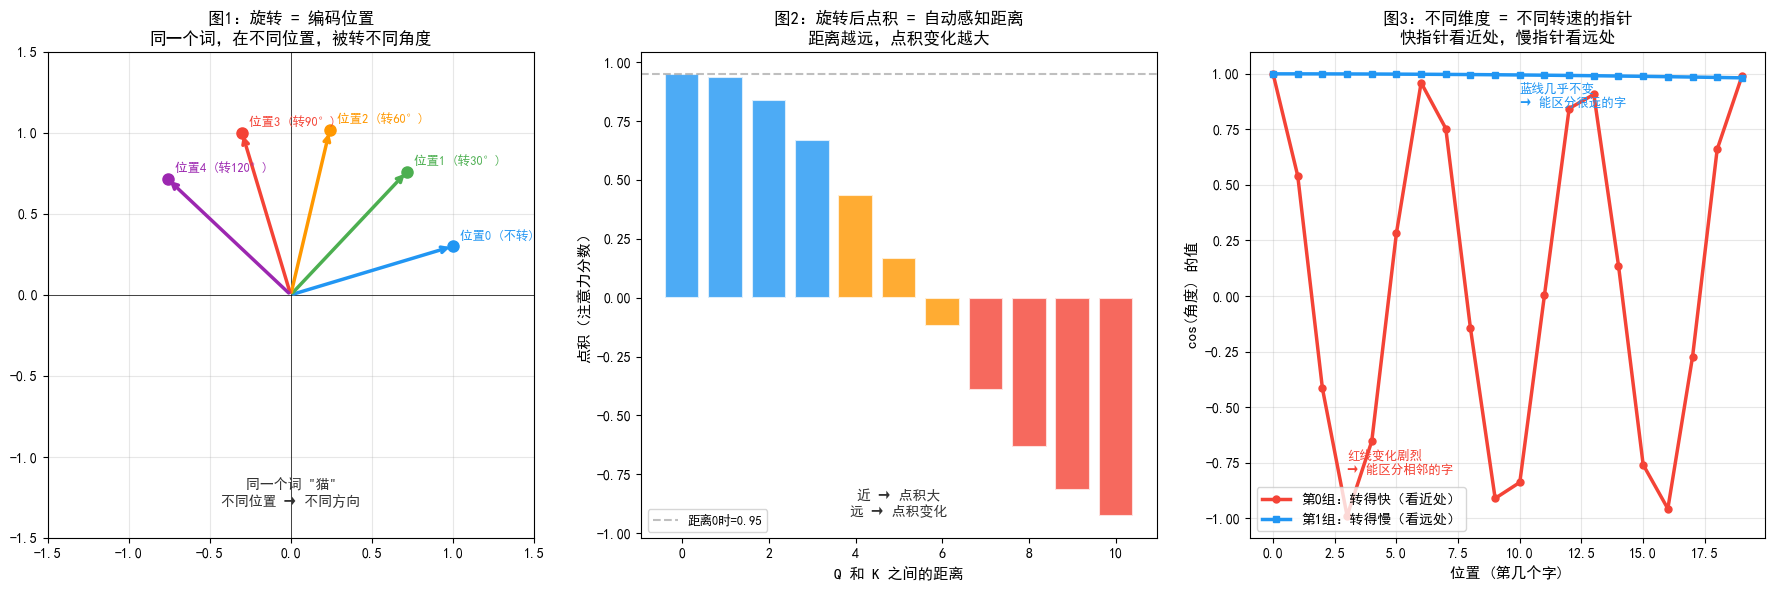


╔══════════════════════════════════════════════════════════════╗
║                    RoPE 三句话总结                           ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  图1: 同一个词在不同位置 → 向量被转不同角度                  ║
║       这样模型就知道每个词在哪了                             ║
║                                                              ║
║  图2: 两个词的向量做点积时，结果自动包含它们的距离           ║
║       不需要额外告诉模型"这两个词隔了几个位置"               ║
║                                                              ║
║  图3: 向量的不同维度用不同转速                               ║
║       快的维度区分近处的词，慢的维度区分远处的词              ║
║       就像时钟：秒针区分秒，时针区分小时                     ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝



In [18]:
# ========== 🎨 RoPE 可视化：一看就懂 ==========
# 不需要任何数学基础，看图就行！

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ============ 图1：什么是旋转？ ============
ax = axes[0]
ax.set_title('图1：旋转 = 编码位置\n同一个词，在不同位置，被转不同角度', fontsize=12, fontweight='bold')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)

# 原始向量（代表"猫"这个词）
original = torch.tensor([1.0, 0.3])
colors = ['#2196F3', '#4CAF50', '#FF9800', '#F44336', '#9C27B0']
labels = ['位置0 (不转)', '位置1 (转30°)', '位置2 (转60°)', '位置3 (转90°)', '位置4 (转120°)']

for i, (color, label) in enumerate(zip(colors, labels)):
    angle = i * math.pi / 6  # 每个位置转30度
    rotated = rotate_2d(original, angle)
    ax.annotate('', xy=(rotated[0].item(), rotated[1].item()), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color=color, lw=2.5))
    ax.plot(rotated[0].item(), rotated[1].item(), 'o', color=color, markersize=8)
    ax.annotate(label, xy=(rotated[0].item(), rotated[1].item()),
                fontsize=9, color=color, fontweight='bold',
                xytext=(5, 5), textcoords='offset points')

ax.annotate('同一个词 "猫"\n不同位置 → 不同方向', xy=(0, -1.3), fontsize=10,
            ha='center', style='italic', color='#333')

# ============ 图2：为什么转？点积自动包含距离！ ============
ax = axes[1]
ax.set_title('图2：旋转后点积 = 自动感知距离\n距离越远，点积变化越大', fontsize=12, fontweight='bold')

q_vec = torch.tensor([1.0, 0.5])
k_vec = torch.tensor([0.8, 0.3])
theta = 0.3

distances = list(range(0, 11))
dot_products = []
for d in distances:
    q_rot = rotate_2d(q_vec, 0 * theta)      # Q 固定在位置0
    k_rot = rotate_2d(k_vec, d * theta)       # K 在位置d
    dot_products.append(dot_product(q_rot, k_rot).item())

bars = ax.bar(distances, dot_products, color=['#2196F3' if d <= 3 else '#FF9800' if d <= 6 else '#F44336' for d in distances],
              alpha=0.8, edgecolor='white', linewidth=1.5)
ax.set_xlabel('Q 和 K 之间的距离', fontsize=11)
ax.set_ylabel('点积（注意力分数）', fontsize=11)
ax.axhline(y=dot_products[0], color='gray', linestyle='--', alpha=0.5, label=f'距离0时={dot_products[0]:.2f}')
ax.legend(fontsize=9)

ax.annotate('近 → 点积大\n远 → 点积变化', xy=(5, min(dot_products)),
            fontsize=10, ha='center', color='#333', style='italic')

# ============ 图3：多根指针，不同转速 ============
ax = axes[2]
ax.set_title('图3：不同维度 = 不同转速的指针\n快指针看近处，慢指针看远处', fontsize=12, fontweight='bold')

positions = list(range(20))
# 快指针（第0组，频率=1.0）
fast = [math.cos(p * 1.0) for p in positions]
# 慢指针（第1组，频率=0.01）
slow = [math.cos(p * 0.01) for p in positions]

ax.plot(positions, fast, 'o-', color='#F44336', linewidth=2.5, markersize=5, label='第0组：转得快（看近处）')
ax.plot(positions, slow, 's-', color='#2196F3', linewidth=2.5, markersize=5, label='第1组：转得慢（看远处）')
ax.set_xlabel('位置 (第几个字)', fontsize=11)
ax.set_ylabel('cos(角度) 的值', fontsize=11)
ax.legend(fontsize=10, loc='lower left')
ax.grid(True, alpha=0.3)

ax.annotate('红线变化剧烈\n→ 能区分相邻的字', xy=(3, -0.8), fontsize=9, color='#F44336', fontweight='bold')
ax.annotate('蓝线几乎不变\n→ 能区分很远的字', xy=(10, 0.85), fontsize=9, color='#2196F3', fontweight='bold')

plt.tight_layout()
plt.savefig('rope_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("""
╔══════════════════════════════════════════════════════════════╗
║                    RoPE 三句话总结                           ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  图1: 同一个词在不同位置 → 向量被转不同角度                  ║
║       这样模型就知道每个词在哪了                             ║
║                                                              ║
║  图2: 两个词的向量做点积时，结果自动包含它们的距离           ║
║       不需要额外告诉模型"这两个词隔了几个位置"               ║
║                                                              ║
║  图3: 向量的不同维度用不同转速                               ║
║       快的维度区分近处的词，慢的维度区分远处的词              ║
║       就像时钟：秒针区分秒，时针区分小时                     ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")

In [15]:
# ========== 高维 RoPE 实现 ==========
# 把 D 维向量分成 D/2 组，每组 2 维，分别旋转
# 每组用不同的频率 θ_i = 10000^(-2i/D)

def precompute_rope_freqs(dim, max_seq_len, base=10000.0):
    """
    预计算 RoPE 的频率和角度
    dim: 向量维度（必须是偶数）
    max_seq_len: 最大序列长度
    base: 基础频率（默认 10000）
    """
    # 频率：θ_i = 1 / (base^(2i/dim))
    # i = 0, 1, 2, ..., dim/2 - 1
    freqs = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
    
    # 位置：0, 1, 2, ..., max_seq_len - 1
    positions = torch.arange(max_seq_len).float()
    
    # 角度矩阵：(seq_len, dim/2)
    # angles[pos, i] = pos * θ_i
    angles = torch.outer(positions, freqs)
    
    # 返回 cos 和 sin
    return torch.cos(angles), torch.sin(angles)

# 测试
dim = 4
max_len = 5
cos_cached, sin_cached = precompute_rope_freqs(dim, max_len)

print(f"维度: {dim}, 最大长度: {max_len}")
print(f"cos shape: {cos_cached.shape}")  # (5, 2)
print(f"cos:\n{cos_cached}")
print(f"\nsin:\n{sin_cached}")

维度: 4, 最大长度: 5
cos shape: torch.Size([5, 2])
cos:
tensor([[ 1.0000,  1.0000],
        [ 0.5403,  0.9999],
        [-0.4161,  0.9998],
        [-0.9900,  0.9996],
        [-0.6536,  0.9992]])

sin:
tensor([[ 0.0000,  0.0000],
        [ 0.8415,  0.0100],
        [ 0.9093,  0.0200],
        [ 0.1411,  0.0300],
        [-0.7568,  0.0400]])


In [19]:
# ========== 应用 RoPE 到向量 ==========
# 把向量分成两半：[x0, x1, x2, x3] → [x0, x1] 和 [x2, x3]
# 每对做 2D 旋转

def apply_rope(x, cos, sin):
    """
    对输入 x 应用 RoPE
    x: (batch, seq_len, dim) 或 (batch, heads, seq_len, head_dim)
    cos, sin: (seq_len, dim/2)
    """
    # 获取序列长度
    seq_len = x.shape[-2]
    dim = x.shape[-1]
    
    # 取对应长度的 cos/sin
    cos = cos[:seq_len]  # (seq_len, dim/2)
    sin = sin[:seq_len]
    
    # 把 x 分成两半
    x1 = x[..., :dim//2]  # 前半部分
    x2 = x[..., dim//2:]  # 后半部分
    
    # 旋转公式：
    # x1_new = x1 * cos - x2 * sin
    # x2_new = x1 * sin + x2 * cos
    x1_new = x1 * cos - x2 * sin
    x2_new = x1 * sin + x2 * cos
    
    # 拼接回去
    return torch.cat([x1_new, x2_new], dim=-1)

# 测试
batch_size = 2
seq_len = 5
dim = 4

# 随机输入
x = torch.randn(batch_size, seq_len, dim)
print(f"输入 x shape: {x.shape}")
print(f"输入 x[0]:\n{x[0]}")

# 应用 RoPE
x_rope = apply_rope(x, cos_cached, sin_cached)
print(f"\nRoPE 后 shape: {x_rope.shape}")
print(f"RoPE 后 x[0]:\n{x_rope[0]}")

输入 x shape: torch.Size([2, 5, 4])
输入 x[0]:
tensor([[ 1.3046, -0.3738,  0.6067,  0.0296],
        [-0.6655, -0.3668, -0.2355,  0.0957],
        [-0.0087, -0.6155,  0.5495,  0.1846],
        [-0.1248, -0.0347, -1.0981, -0.8466],
        [-0.4683,  1.8765,  0.3622,  0.1305]])

RoPE 后 shape: torch.Size([2, 5, 4])
RoPE 后 x[0]:
tensor([[ 1.3046, -0.3738,  0.6067,  0.0296],
        [-0.1614, -0.3677, -0.6872,  0.0921],
        [-0.4960, -0.6190, -0.2365,  0.1722],
        [ 0.2785, -0.0093,  1.0695, -0.8472],
        [ 0.5802,  1.8698,  0.1177,  0.2054]])


In [17]:
# ========== 带 RoPE 的 Multi-Head Attention ==========

class RoPEMultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, max_seq_len=512):
        super().__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        
        self.W_Q = nn.Linear(model_dim, model_dim)
        self.W_K = nn.Linear(model_dim, model_dim)
        self.W_V = nn.Linear(model_dim, model_dim)
        self.W_O = nn.Linear(model_dim, model_dim)
        
        # 预计算 RoPE 的 cos/sin
        cos, sin = precompute_rope_freqs(self.head_dim, max_seq_len)
        self.register_buffer('cos_cached', cos)
        self.register_buffer('sin_cached', sin)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 1. 线性变换
        Q = self.W_Q(query)
        K = self.W_K(key)
        V = self.W_V(value)
        
        # 2. 拆成多头 (batch, seq, dim) → (batch, heads, seq, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 3. 对 Q 和 K 应用 RoPE（V 不需要）
        Q = apply_rope(Q, self.cos_cached, self.sin_cached)
        K = apply_rope(K, self.cos_cached, self.sin_cached)
        
        # 4. 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # 5. 应用 mask
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(~mask, -1e9)
        
        # 6. softmax
        attn_weights = F.softmax(scores, dim=-1)
        
        # 7. 加权求和
        attn_output = torch.matmul(attn_weights, V)
        
        # 8. 拼接多头
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.model_dim)
        
        # 9. 输出投影
        return self.W_O(attn_output)


# 测试
rope_attn = RoPEMultiHeadAttention(model_dim=4, num_heads=2, max_seq_len=100)

# 使用之前的输入
output = rope_attn(src_input, src_input, src_input, encoder_self_attn_mask)

print(f"输入 shape: {src_input.shape}")
print(f"输出 shape: {output.shape}")
print(f"输出:\n{output}")

输入 shape: torch.Size([2, 5, 4])
输出 shape: torch.Size([2, 5, 4])
输出:
tensor([[[ 0.1077, -0.3574,  0.3070,  0.1932],
         [ 0.0754, -0.3980,  0.2655,  0.1761],
         [ 0.5563, -0.2519,  0.5573, -0.0081],
         [ 0.5563, -0.2519,  0.5573, -0.0081],
         [ 0.5563, -0.2519,  0.5573, -0.0081]],

        [[ 0.1624, -0.4247,  0.2849,  0.0821],
         [ 0.2160, -0.3774,  0.3066,  0.1383],
         [ 0.2540, -0.3696,  0.3297,  0.1203],
         [ 0.2521, -0.3846,  0.3339,  0.0831],
         [ 0.4039, -0.3098,  0.4494,  0.0435]]], grad_fn=<ViewBackward0>)


### 总结

RoPE（Rotary Position Embedding）用旋转代替加法编码位置：

**正弦编码 vs RoPE：**

| 对比 | 正弦编码 | RoPE |
|------|----------|------|
| 方式 | 加法：`x + PE` | 旋转：`rotate(x, θ)` |
| 位置类型 | 绝对位置 | **相对位置** |
| 应用对象 | Embedding | **Q 和 K** |
| 使用模型 | 原版 Transformer | LLaMA, Qwen, ChatGLM |

**核心思想：**
```
位置 m 的 Q 旋转 m*θ
位置 n 的 K 旋转 n*θ
点积 Q·K 自然包含相对位置 (m-n)
```

**2D 旋转公式：**
```
[x']   [cos(θ)  -sin(θ)] [x]
[y'] = [sin(θ)   cos(θ)] [y]
```

**高维实现：**
- 把 D 维分成 D/2 组，每组 2 维
- 每组用不同频率 θ_i = 1/10000^(2i/D)
- 分别做 2D 旋转

**代码关键：**
```python
# 1. 预计算频率
freqs = 1.0 / (10000 ** (torch.arange(0, dim, 2) / dim))
angles = positions * freqs  # (seq_len, dim/2)

# 2. 应用旋转（只对 Q 和 K）
x1_new = x1 * cos - x2 * sin
x2_new = x1 * sin + x2 * cos
```

**为什么 V 不需要 RoPE？**
- RoPE 的目的是让 Q·K 包含相对位置
- V 是被加权求和的内容，不参与位置计算

**RoPE 的优势：**
1. 相对位置：注意力分数只和距离有关
2. 外推性好：能处理比训练更长的序列
3. 计算高效：只需要逐元素乘法